In [117]:
#importing packages

import sys
import os
import numpy as np
import argparse
import os
from skimage import io, color, exposure, transform
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using keras and tensorflow as the main libraries for image classification. CNN model has been used for the same.

In [118]:
DEV = False
argvs = sys.argv
argc = len(argvs)

declaring the necessary number of epoch for best accuracy

In [119]:
if argc > 1 and (argvs[1] == "--development" or argvs[1] == "-d"):
  DEV = True

if DEV:
  epochs = 2
else:
  epochs = 20

In [120]:
# parameters

img_width, img_height = 32, 32
batch_size = 32
samples_per_epoch = 1000
validation_steps = 300
nb_filters1 = 32
conv1_size = 5
pool_size = 2
classes_num = 5
lr = 0.0004



Building the different layers of the CNN Model

Batch normalization is a technique for improving the performance and stability of artificial neural networks. It is a technique to provide any layer in a neural network with inputs that are zero mean/unit variance.

Maxpooling is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting.

Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. 

In [121]:
def build_cnn(input_size, num_classes):
    model = Sequential()
    
    model.add(Convolution2D(nb_filters1, conv1_size, conv1_size, border_mode ="same", input_shape=(img_width, img_height, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(Convolution2D(nb_filters1, conv1_size, conv1_size, border_mode ="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size), dim_ordering='th'))

    model.add(Convolution2D(nb_filters1, conv1_size, conv1_size, border_mode ="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Flatten())
    
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=lr),
                  metrics=['accuracy'])
    return model

In [122]:
model = build_cnn(32,5)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_normalization_22 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_39 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 32)        25632     
_________________________________________________________________
batch_normalization_23 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_40 (Activation)   (None, 16, 16, 32)        0         
__________

In [123]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [124]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

Defining functions to load and train data set. 

The given data set was divided into two subsets namely--train and test in 0.9-0.1 ratio.

Further, the validation data set is 90% of the train data set. 

In [125]:
def load_data(path, val_size=0.1):
    if not os.path.exists(path):
        raise IOError('directory does not exist')
    classes = os.listdir(path)
    class2idx = {c: i for i, c in enumerate(classes)}
    X = []
    y = []
    for c in classes:
        cp = os.path.join(path, c)
        img_paths = os.listdir(cp)
        label = np.zeros(len(classes), dtype=np.float32)
        label[class2idx[c]] = 1.0
        for ip in img_paths:
            img = Image.open(os.path.join(cp, ip))
            img = img.resize((32, 32))
            img = np.array(img, dtype=np.float32) / 255.0
            X.append(img)
            y.append(label)
    
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_size)

    return X_train, X_test, y_train, y_test, class2idx

def load_test(path):
    if not os.path.exists(path):
        raise IOError('directory does not exist')
    classes = os.listdir(path)
    class2idx = {c: i for i, c in enumerate(classes)}
    X = []
    y = []
    for c in classes:
        cp = os.path.join(path, c)
        img_paths = os.listdir(cp)
        label = np.zeros(len(classes), dtype=np.float32)
        label[class2idx[c]] = 1.0
        for ip in img_paths:
            img = Image.open(os.path.join(cp, ip))
            img = img.resize((32, 32))
            img = np.array(img, dtype=np.float32) / 255.0
            X.append(img)
            y.append(label)
    
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)


    return X,y,class2idx

X_train, X_test, y_train, y_test, class2idx = load_data(path="/home/nitin/Desktop/dsc/train/")
print(class2idx)

{'tulip': 0, 'rose': 1, 'sunflower': 2, 'dandelion': 3, 'daisy': 4}


In [127]:
"""
Tensorboard log
"""
log_dir = './tf-log/'
tb_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
callbacks = [tb_cb]

Epoch running on the training and validation data set. 

It has been set to 20 epoch after various tests for the best accuracy. 

In [128]:
model.fit(x=X_train, 
          y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=(X_test, y_test),
          shuffle=True,
          )


model.save_weights('model.h5')

Train on 3501 samples, validate on 390 samples
Epoch 1/20
3501/3501 [==============================] - 55s 16ms/step - loss: 1.7572 - acc: 0.2962 - val_loss: 1.2944 - val_acc: 0.4667
Epoch 2/20
3501/3501 [==============================] - 50s 14ms/step - loss: 1.4203 - acc: 0.4170 - val_loss: 1.2528 - val_acc: 0.4821
Epoch 3/20
3501/3501 [==============================] - 53s 15ms/step - loss: 1.3383 - acc: 0.4544 - val_loss: 1.4578 - val_acc: 0.4231
Epoch 4/20
3501/3501 [==============================] - 53s 15ms/step - loss: 1.2563 - acc: 0.4904 - val_loss: 1.1493 - val_acc: 0.5077
Epoch 5/20
3501/3501 [==============================] - 51s 15ms/step - loss: 1.1964 - acc: 0.5170 - val_loss: 1.0241 - val_acc: 0.5897
Epoch 6/20
3501/3501 [==============================] - 52s 15ms/step - loss: 1.1485 - acc: 0.5461 - val_loss: 1.0739 - val_acc: 0.5615
Epoch 7/20
3501/3501 [==============================] - 57s 16ms/step - loss: 1.0841 - acc: 0.5867 - val_loss: 0.9651 - val_acc: 0.5872
E

In [129]:
target_dir = './models/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model.save('./models/model.h5')
model.save_weights('./models/weights.h5')

In [130]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model

In [131]:
img_width, img_height = 32, 32
model_path = './models/model.h5'
model_weights_path = './models/weights.h5'
model = load_model(model_path)
model.load_weights(model_weights_path)

In [132]:
model.load_weights('model.h5')

class2idx = {'tulip': 0, 'rose': 1, 'sunflower': 2, 'dandelion': 3, 'daisy': 4}

idx2class = {v: key for key, v in class2idx.items()}

In [133]:
# loading the test data ..

X_test,Y_test, class2idx = load_test(path="/home/nitin/Desktop/dsc/test/")	
X_test = X_test.reshape(X_test.shape[0],32,32,3)

In [134]:
score = model.evaluate(X_test, Y_test, verbose=0)

The accuracy for the test data set is as follows--

In [135]:
print('Test accuracy:', score[1])

Test accuracy: 0.8770301626895807


In [140]:
#noting the correct class for all the predictions made from Y_test
correct_class = []
for i in range(len(Y_test)):
    for j in range(len(Y_test[i])):
        if(Y_test[i][j] == 1.0):
            correct_class.append(j)

In [141]:
print(correct_class)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

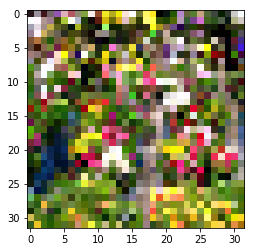

Predicted as-> daisy
Correct class-> tulip


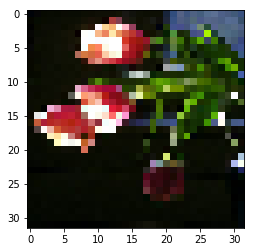

Predicted as-> daisy
Correct class-> tulip


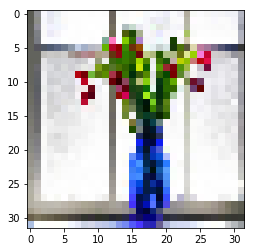

Predicted as-> daisy
Correct class-> tulip


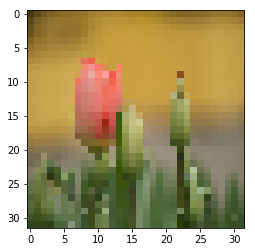

Predicted as-> dandelion
Correct class-> tulip


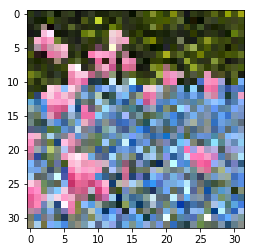

Predicted as-> daisy
Correct class-> tulip


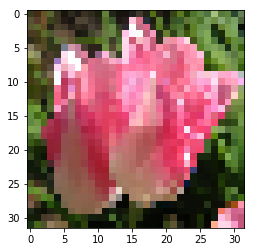

Predicted as-> rose
Correct class-> tulip


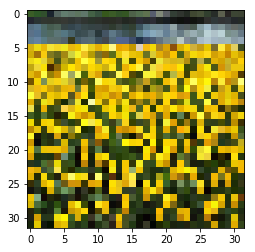

Predicted as-> dandelion
Correct class-> tulip


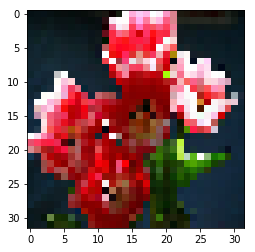

Predicted as-> rose
Correct class-> tulip


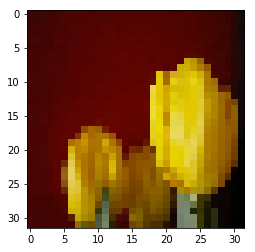

Predicted as-> rose
Correct class-> tulip


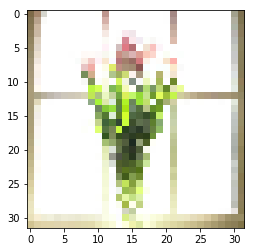

Predicted as-> daisy
Correct class-> tulip


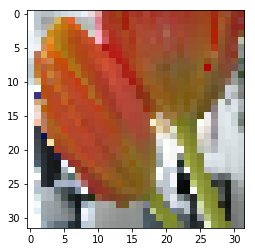

Predicted as-> daisy
Correct class-> tulip


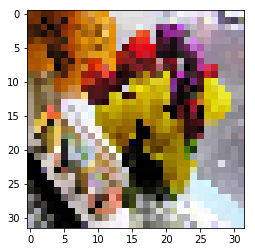

Predicted as-> daisy
Correct class-> tulip


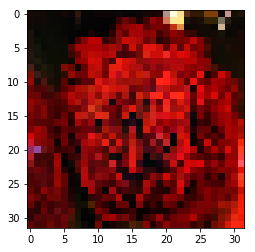

Predicted as-> tulip
Correct class-> rose


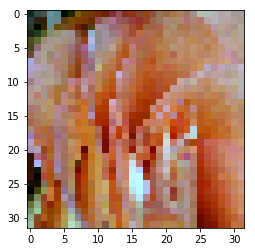

Predicted as-> tulip
Correct class-> rose


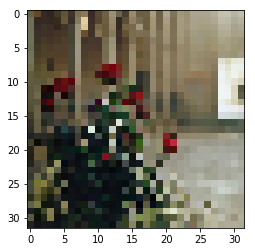

Predicted as-> daisy
Correct class-> rose


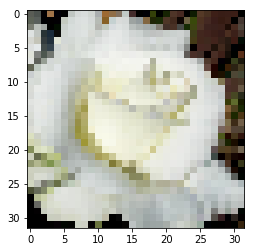

Predicted as-> daisy
Correct class-> rose


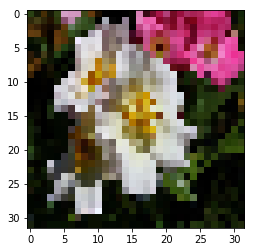

Predicted as-> daisy
Correct class-> rose


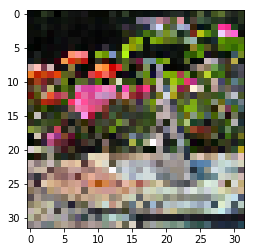

Predicted as-> tulip
Correct class-> rose


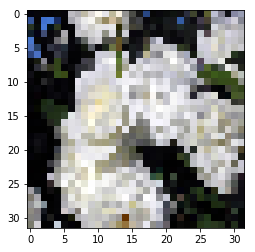

Predicted as-> daisy
Correct class-> rose


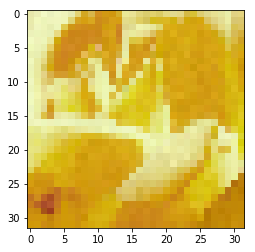

Predicted as-> daisy
Correct class-> rose


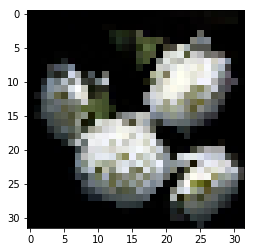

Predicted as-> daisy
Correct class-> rose


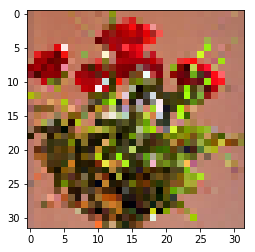

Predicted as-> tulip
Correct class-> rose


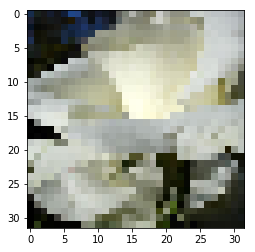

Predicted as-> daisy
Correct class-> rose


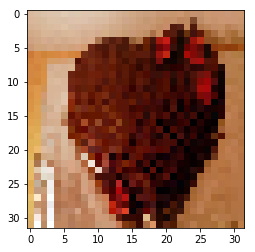

Predicted as-> sunflower
Correct class-> rose


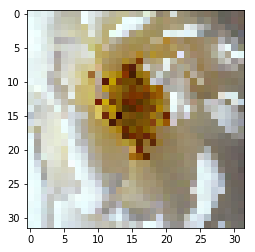

Predicted as-> daisy
Correct class-> rose


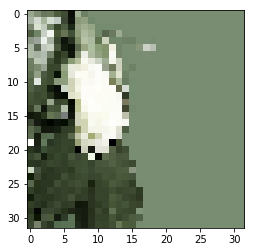

Predicted as-> dandelion
Correct class-> rose


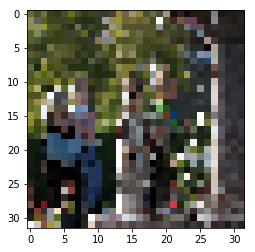

Predicted as-> tulip
Correct class-> rose


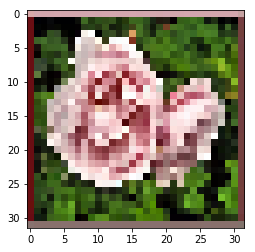

Predicted as-> daisy
Correct class-> rose


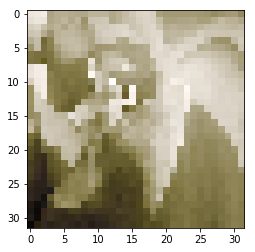

Predicted as-> dandelion
Correct class-> rose


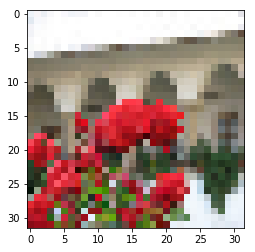

Predicted as-> tulip
Correct class-> rose


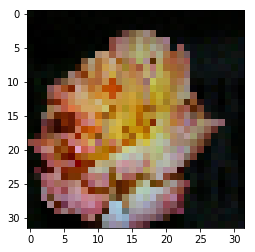

Predicted as-> daisy
Correct class-> rose


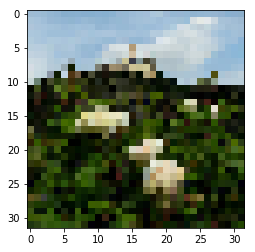

Predicted as-> daisy
Correct class-> rose


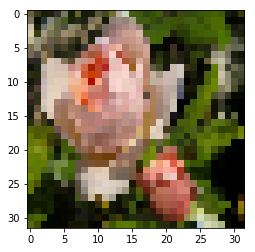

Predicted as-> daisy
Correct class-> rose


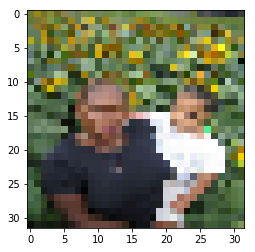

Predicted as-> daisy
Correct class-> sunflower


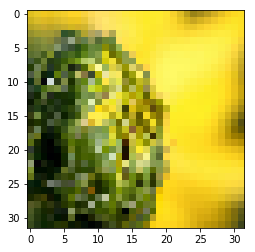

Predicted as-> dandelion
Correct class-> sunflower


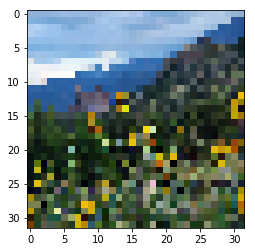

Predicted as-> tulip
Correct class-> sunflower


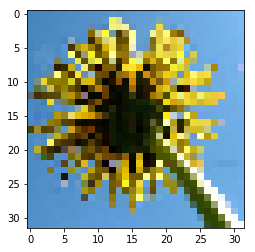

Predicted as-> sunflower
Correct class-> dandelion


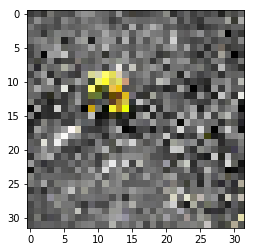

Predicted as-> daisy
Correct class-> dandelion


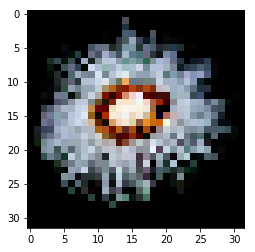

Predicted as-> daisy
Correct class-> dandelion


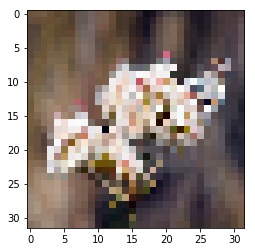

Predicted as-> daisy
Correct class-> dandelion


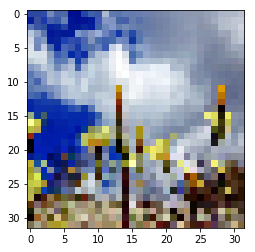

Predicted as-> daisy
Correct class-> dandelion


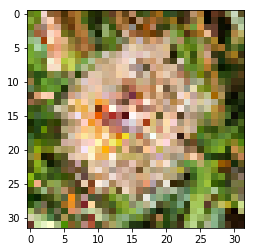

Predicted as-> daisy
Correct class-> dandelion


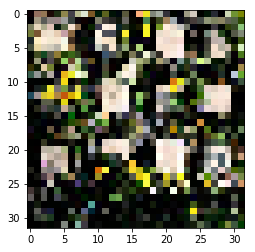

Predicted as-> daisy
Correct class-> dandelion


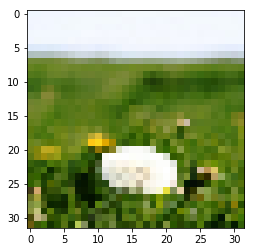

Predicted as-> daisy
Correct class-> dandelion


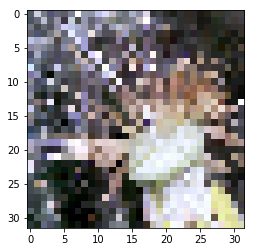

Predicted as-> daisy
Correct class-> dandelion


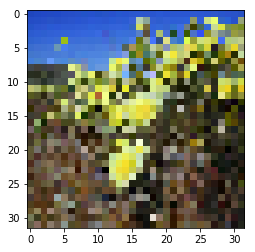

Predicted as-> sunflower
Correct class-> dandelion


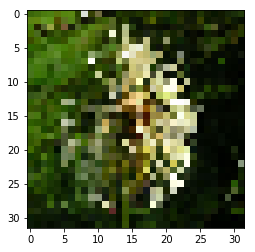

Predicted as-> daisy
Correct class-> dandelion


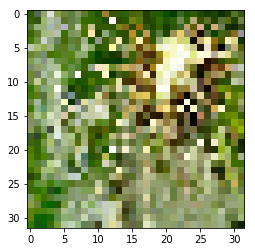

Predicted as-> daisy
Correct class-> dandelion


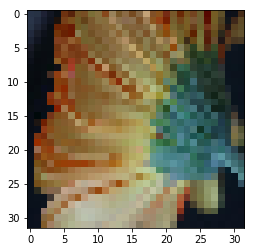

Predicted as-> dandelion
Correct class-> daisy


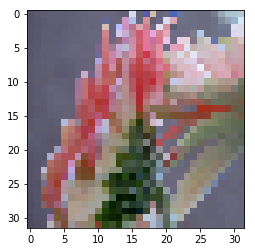

Predicted as-> rose
Correct class-> daisy


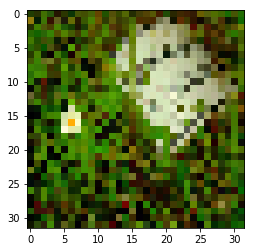

Predicted as-> dandelion
Correct class-> daisy


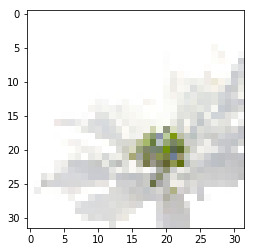

Predicted as-> dandelion
Correct class-> daisy


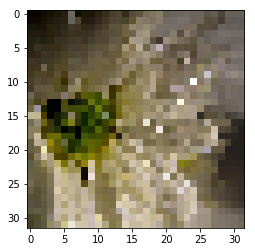

Predicted as-> dandelion
Correct class-> daisy


In [142]:
#showing the incorrectly predicted flowers 
from matplotlib import pyplot as plt
for i in range(len(y_pred)):
    if(y_pred[i] != correct_class[i]):
        plt.imshow(X_test[i], interpolation='nearest')
        plt.show()
        print('Predicted as->', idx2class[(y_pred[i])])
        print('Correct class->', idx2class[(correct_class[i])])